In [78]:
import pandas as pd 
import numpy as np 
import pathlib as path
import matplotlib.pyplot as plt
import random
from PIL import Image
from random import sample
from cmath import nan
import json

from scipy import stats


In [79]:
#define the relevant path to the current batch you wish to parse
gap_name='pilot_two_week' #dont change this as this parsing sciprt only handles the same day batches.  

project_name='birds'
experiment_name='experiment 1'
batch_name='batch 1'
qualification_method='loose' #or 'loose'  - defines different disqualification criterions (add this suffix to the saved file)
PATH_TO_BATCH=path.Path.cwd().parent.parent.parent / 'projects' / project_name / experiment_name / 'collected data' / gap_name / batch_name
PATH_TO_BATCH_DATA = PATH_TO_BATCH / 'data'

if PATH_TO_BATCH.exists():
    print('batch folder found at:\n' ,PATH_TO_BATCH)
else: 
    print('path to batch is non existent:\n',PATH_TO_BATCH)

batch folder found at:
 c:\Users\User\Desktop\visual_memory_project\visual-memory-project\projects\birds\experiment 1\collected data\pilot_two_week\batch 1


In [80]:

qualification_name_for_testin='UPDATE-completed encoding successfully ' #note that the -space- after the title is improtant as for some reason this is how the qualification name is defined
qualification_name_for_entire_experiment='UPDATE-completed birds memory rep'



In [81]:
def set_criterions(type='strict'):
    #the function sets the criterions and returns them as a pd.series
    criterions_df=pd.Series(dtype=float)

    #update the non changing ciretrions: 
    criterions_df['demo_arrow_correctness']=1
    criterions_df['encoding_arrow_accuracy']=0.6
    criterions_df['longest_allowed_consequtive_strike']=15
    criterions_df['fast_threshold']=0.3

    if type=='strict':
        criterions_df['demo_accuracy_treshold']=0.5 
        
        criterions_df['fast_allowed_count']=3 
        criterions_df['slow_threshold']=10
        criterions_df['slow_allowed_count']=2
        criterions_df['binom_single_layer']=0.75
        criterions_df['binom_averages']=0.61
    elif type=='loose': #here we change things to be easier to pass
        criterions_df['demo_accuracy_treshold']=0
        criterions_df['fast_threshold']=0.3
        criterions_df['fast_allowed_count']=5 
        criterions_df['slow_threshold']=15
        criterions_df['slow_allowed_count']=5
        criterions_df['binom_single_layer']=0.55
        criterions_df['binom_averages']=0.55
    else: 
        raise Exception('requested method is not defined')
    
    return criterions_df


In [82]:

criterions_df=set_criterions(qualification_method)
criterions_df

demo_arrow_correctness                 1.00
encoding_arrow_accuracy                0.60
longest_allowed_consequtive_strike    15.00
fast_threshold                         0.30
demo_accuracy_treshold                 0.00
fast_allowed_count                     5.00
slow_threshold                        15.00
slow_allowed_count                     5.00
binom_single_layer                     0.55
binom_averages                         0.55
dtype: float64

In [83]:
#this section loads the shelf dict in the state it is after finishing the testing session for this batch. 
shelf_dict_after_test_name=PATH_TO_BATCH / 'shelf after test session closed.txt' #define the name of the relevant shelf for this stage
with open(shelf_dict_after_test_name) as f:
    data = f.read()
shelf_dict = json.loads(data)
shelf_dict


{'A2541C8MY0BYV3': [0,
  1675267981506,
  1676383763427,
  1676386591184,
  1676396903851],
 'A3RCX3IQ8L6HHW': [1, 1675268029753, None],
 'ALCPF5NANBDSZ': [2, 1675268048545, 1676405406780],
 'A2LI71A9ZRA199': [3, 1675268051443, 1676446070481],
 'A1AMGHYG5PT0L2': [3,
  1675268055067,
  1676383561407,
  1676383655265,
  1676396853301],
 'AX9LZ0N55O19E': [4, 1675268071765, 1676375321654],
 'A28HB7240OFGEW': [999, 1675268100057],
 'A3S10MQO4RXHM8': [6, 1675268108691, 1676380541177],
 'A1A71I3P1FXWCD': [999, 999, 999],
 'A1JJYY622DGE5L': [8, 1675268140997],
 'A10YV3PH9V9KQP': [9, 1675268157717, 1676374586692, 1676374915245],
 'A72YC75DZ8OLE': [999, 999, 999],
 'A146QN6EU8LAEI': [10,
  1675268305246,
  1676374592899,
  1676374725332,
  1676381532863,
  1676430249300],
 'A34PI07YOEU3ZS': [999, 999, 999],
 'A29C1SVJECJ1V8': [999, 999, 999],
 'AOMYFDVVIRWN2': [999, 999, 999],
 'A1TIKB6CAQFH2B': [999, 999, 999],
 'A3QHZCELFJ3BSN': [11,
  1675268724743,
  1676375052027,
  1676375122905,
  1676380

In [84]:
#this section reads all the relevant files: 
if (PATH_TO_BATCH / 'Batch_encoding_batch_results.csv').exists():
    encoding_df=pd.read_csv(PATH_TO_BATCH / 'Batch_encoding_batch_results.csv')
else: 
    print(f'no "Batch_encoding_batch_results.csv" was found in data')

if (PATH_TO_BATCH / 'Batch_testing_batch_results.csv').exists():
    testing_df=pd.read_csv(PATH_TO_BATCH / 'Batch_testing_batch_results.csv')
else: 
    print(f'no "Batch_testing_batch_results.csv" was found in data (probably because only the encoding session finished)')
if (PATH_TO_BATCH / 'Batch_workers_after_test.csv').exists():
    workers_df=pd.read_csv(PATH_TO_BATCH / 'Batch_workers_after_test.csv')
else:
    print('No AMAZON worker list was found: please make sure to upload one and name it correctly')



In [85]:
def find_largest_consequtive_repetition(responses_array):
#add a stop value so the loop will use the logic also if the end of the responses is all repeating: 
    responses_array=np.append(responses_array,[99])
    longest_rep_dict=dict()
    last_input=responses_array[0]
    consequtive_rep_counter=0
    for response in responses_array[1:]: 
        if response==last_input: #if consequtive rep: 
            consequtive_rep_counter=consequtive_rep_counter+1 #add to counter
        else: #once a new entry is in the vector - store the counter rep information 
            if last_input in longest_rep_dict.keys(): #if it was allready stored in our dictionary
                if longest_rep_dict[last_input]<consequtive_rep_counter: #replace the counter only if it is higher than what stored in dict
                    longest_rep_dict[last_input]=consequtive_rep_counter
            else: #this entry is not yet in the dictionary: add it 
                longest_rep_dict[last_input]=consequtive_rep_counter
            
            consequtive_rep_counter=0
            last_input=response
    return max(longest_rep_dict.values())

In [86]:
def process_worker_results(PATH_TO_BATCH_DATA,subject_name,parse_type='encoding'):
    cur_sub=pd.read_csv(PATH_TO_BATCH_DATA / subject_name)
    sub_demographics=cur_sub[['workID','Age','Gender']].iloc[0]

    #extract demo related information: 

    #if participant did not click on the arrow during the demo a 'demo_encoding_response.rt' colmumn wont exists: 
    #thus we will create one and fill it with nans (so everything will be consistent with other participants)
    demo_columns=['demo_encoding_loop.thisTrialN','DemoImage','DemoCorrect','demo_encoding_response.rt','demo_encoding_response.keys']
    demo_test_columns=['demo_test_response.keys','demo_test_response.corr','demo_test_response.rt','demo_test_loop.thisTrialN','DemoImage1','DemoImage2','DemoCorrectTest']
    encoding_related_columns=['test_encoding_response.keys','test_encoding_response.corr','trials.thisTrialN','target_image','pair','layer','correct','test_encoding_response.rt','key_resp_end.keys']
    test_related_columns=['layer','correct','test_test_response.keys','test_test_response.corr','test_test_response.rt','trials_2.thisRepN','trials_2.thisTrialN','trials_2.thisN','trials_2.thisIndex','trials_2.ran','image1','image2']

    if not('demo_encoding_response.rt' in cur_sub.columns):
        cur_sub['demo_encoding_response.rt']=np.nan  

    if (parse_type=='encoding'):
        sub_demo_information=cur_sub[demo_columns]
        empty_inds=sub_demo_information.loc[sub_demo_information.isnull().apply(lambda x: all(x), axis=1)].index
        #drop irrelevant columns: 
        sub_demo_information=sub_demo_information.drop(index=empty_inds)


        #extract the demo test columns: 
        sub_demo_test_information=cur_sub[demo_test_columns]
        empty_inds=sub_demo_test_information.loc[sub_demo_test_information.isnull().apply(lambda x: all(x), axis=1)].index
        #drop irrelevant columns: 
        sub_demo_test_information=sub_demo_test_information.drop(index=empty_inds)

        demo_df=pd.concat([sub_demo_information.reset_index(),sub_demo_test_information.reset_index()],axis=1)

    #extract real experiment related information: 

    #if participant did not click on the arrow during the encoding a 'test_encoding_response.rt' column wont exists: 
    #thus we will create one and fill it with nans (so everything will be consistent with other participants)
    if not('test_encoding_response.rt' in cur_sub.columns):
        cur_sub['test_encoding_response.rt']=np.nan
        

    if (parse_type=='encoding') | (parse_type=='all'):
        sub_encoding_information=cur_sub[encoding_related_columns]
        #encoding section ends with a key press of the space key: so seperate this phase by finding this space key row
        end_of_section_ind=np.where(sub_encoding_information['key_resp_end.keys']=='space')[0][0]
        sub_encoding_information=sub_encoding_information.iloc[0:end_of_section_ind]
        #remove all the rows that precede the real encoding phase: 
        empty_inds=sub_encoding_information.loc[sub_encoding_information.isnull().apply(lambda x: all(x), axis=1)].index
        sub_encoding_information=sub_encoding_information.drop(index=empty_inds).reset_index()

    if (parse_type=='test') | (parse_type=='all'):
    #extract real experiment TEST related information: 
        sub_test_information=cur_sub[test_related_columns].dropna()


    subject_dictionary=dict()
    subject_dictionary['demographics']=sub_demographics
    if (parse_type=='encoding') | (parse_type=='all'):
        subject_dictionary['demo_df']=demo_df
    if (parse_type=='encoding') | (parse_type=='all'):
        subject_dictionary['encoding_df']=sub_encoding_information
    if (parse_type=='test') | (parse_type=='all'):
        subject_dictionary['test_df']=sub_test_information

    return subject_dictionary



In [87]:

#get all results with Encoding information - extract the arrow attention check accuracy and RT (RT is currently not usd as a criterion)

#this section extract the list of participants from the downloaded results files (and not via the workers or session list csvs) 
# - it will create the qualification_df (a table with information on the worker ids and encoding behavior of all participants that we have files for)
all_filenames=[file for file in PATH_TO_BATCH_DATA.iterdir() if 'csv' in file.name and 'ENCODING' in file.name]
#print(f'current csv files:\n{all_filenames}')

qualification_for_test_df=pd.DataFrame(columns=['workerID','arrow_acc','mean_arrow_RT'])
for subject_csv in all_filenames:
    print(subject_csv.name)
    subject_dict=process_worker_results(PATH_TO_BATCH_DATA,path.Path(subject_csv))
    cur_sub_encoding=subject_dict['encoding_df']

    sname=subject_csv.name.split('_')[1] #change according to actuall format. 

    #get only attention check related info: 
    cur_sub_encoding=cur_sub_encoding[['test_encoding_response.keys','correct','test_encoding_response.rt']].copy().dropna(how = 'all')
    if len(cur_sub_encoding)==0: #empty - the participant didnt respond on the arrow at all
        arrow_acc=0
        RT=nan
    else: 
        RT=cur_sub_encoding['test_encoding_response.rt'].mean()
        arrow_acc=(cur_sub_encoding['correct']==cur_sub_encoding['test_encoding_response.keys']).mean()
    sub_df=pd.DataFrame({'workerID':sname,'arrow_acc':arrow_acc,'mean_arrow_RT':RT},index=[sname])
    qualification_for_test_df=pd.concat([qualification_for_test_df,sub_df],axis=0)

#the following part update the qualification_df with information on wether the participant id exists in the amazon workers list: 

#change participants qualifications if they exists in the workers list based on thier encoding arrow accuracy
qualification_for_test_df['in_encoding_workers_list']=nan

for curr_worker_ID in qualification_for_test_df.index:
    if curr_worker_ID in encoding_df['WorkerId'].values:
        qualification_for_test_df.loc[curr_worker_ID,'in_encoding_workers_list']=int(1)
    else:
        qualification_for_test_df.loc[curr_worker_ID,'in_encoding_workers_list']=int(0)


ENCODING_A10JXOU89D5RXR_2023-02-01_14h25.35.197.csv
ENCODING_A10YV3PH9V9KQP_2023-02-01_11h15.57.717.csv
ENCODING_A110KENBXU7SUJ_2023-02-03_06h45.01.898.csv
ENCODING_A11BQAB549UAEG_2023-02-01_15h55.58.663.csv
ENCODING_A146QN6EU8LAEI_2023-02-01_11h18.25.246.csv
ENCODING_A178HXQENEAI65_2023-02-01_15h58.04.712.csv
ENCODING_A1AA32T87SP2NV_2023-02-02_24h07.53.231.csv
ENCODING_A1AMGHYG5PT0L2_2023-02-01_11h14.15.067.csv
ENCODING_A1HCJKXZTLF6VI_2023-02-01_11h32.35.877.csv
ENCODING_A1JJYY622DGE5L_2023-02-01_11h15.40.997.csv
ENCODING_A1NVPXNM1PWTXH_2023-02-03_11h27.34.575.csv
ENCODING_A1SARRYNMZDVXB_2023-02-01_11h44.33.675.csv
ENCODING_A1SL10V8CDNI9H_2023-02-01_20h32.21.929.csv
ENCODING_A206WLS4KMBH86_2023-02-01_22h24.38.508.csv
ENCODING_A21YNTPZSVT4QX_2023-02-02_22h16.07.863.csv
ENCODING_A23KAJRDVCVGOE_2023-02-01_13h28.44.944.csv
ENCODING_A2541C8MY0BYV3_2023-02-01_08h13.01.506.csv
ENCODING_A262YEPP7TVFWA_2023-02-01_19h56.25.449.csv
ENCODING_A2APG8MSLJ6G2K_2023-02-01_13h41.58.394.csv
ENCODING_A2C

In [88]:
all_subjects_demo_df=pd.DataFrame()
all_subjects_encoding_df=pd.DataFrame()
all_subjects_test_df=pd.DataFrame()
all_subjects_biographics_df=pd.DataFrame()
all_filenames=[file.name for file in PATH_TO_BATCH_DATA.iterdir() if 'csv' in file.name and 'TEST' in file.name]

for subject_test_filename in all_filenames:
    subject_name=subject_test_filename.split('_')[1]
    subject_encoding_filename=[file.name for file in PATH_TO_BATCH_DATA.iterdir() if 'csv' in file.name and 'ENCODING' in file.name and subject_name in file.name][0]
    curr_subject_dictionary=process_worker_results(PATH_TO_BATCH_DATA,subject_encoding_filename,parse_type='encoding')
    curr_demo_df=curr_subject_dictionary['demo_df']
    curr_demo_df['subject']=subject_name
    curr_encoding_df=curr_subject_dictionary['encoding_df']
    curr_encoding_df['subject']=subject_name
    curr_demographics_df=curr_subject_dictionary['demographics']
    curr_demographics_df['subject']=subject_name

    curr_subject_dictionary=process_worker_results(PATH_TO_BATCH_DATA,subject_test_filename,parse_type='test')
    curr_test_df=curr_subject_dictionary['test_df']
    curr_test_df['subject']=subject_name



    all_subjects_demo_df=pd.concat([all_subjects_demo_df,curr_demo_df],axis=0,ignore_index=True)
    all_subjects_encoding_df=pd.concat([all_subjects_encoding_df,curr_encoding_df],axis=0,ignore_index=True)
    all_subjects_test_df=pd.concat([all_subjects_test_df,curr_test_df],axis=0,ignore_index=True)
    all_subjects_biographics_df=pd.concat([all_subjects_biographics_df,pd.DataFrame(curr_demographics_df).T],axis=0,ignore_index=True)


all_subjects_demo_df.to_csv(PATH_TO_BATCH / 'all_subjects_demo_df.csv')
all_subjects_encoding_df.to_csv(PATH_TO_BATCH / 'all_subjects_encoding_df.csv')
all_subjects_test_df.to_csv(PATH_TO_BATCH / 'all_subjects_test_df.csv')
all_subjects_biographics_df.to_csv(PATH_TO_BATCH / 'all_subjects_biographics_df.csv')

In [89]:
from unicodedata import category

# if there are any empty values - fill with mean of subjects age 
mean_value = all_subjects_biographics_df['Age'].mean()
all_subjects_biographics_df['Age'].fillna(value=mean_value, inplace=True)
all_subjects_biographics_df['Age'] = all_subjects_biographics_df['Age'].astype(np.int64)

all_subjects_biographics_df['Age']=all_subjects_biographics_df['Age'].astype(int)
all_subjects_biographics_df['Gender'].replace({'woman':'female','FEMLAE':'female','Male':'male','MALE':'male','FEMALE':'female','Female':'female','ale':'male','m':'male'},inplace=True)


tot_gender_types = all_subjects_biographics_df['Gender'].values
tot_gender_types = np.delete(tot_gender_types,3)
if len(np.unique(tot_gender_types))<=2:
    print('transformed the gender column to be consistent having two possible values:',set(all_subjects_biographics_df['Gender'].values))
else: 
    print('gender is still inconsistent with more than 2 unique values:',np.unique(all_subjects_biographics_df['Gender'].values))
all_subjects_biographics_df['Gender']=all_subjects_biographics_df['Gender'].astype("category")

mean_age,min_age,max_age=all_subjects_biographics_df['Age'].mean(),all_subjects_biographics_df['Age'].min(),all_subjects_biographics_df['Age'].max()
female_prop=all_subjects_biographics_df.loc[all_subjects_biographics_df['Gender']=='female','Gender'].count()/all_subjects_biographics_df['Gender'].count()

print(f'Mean age: {mean_age:.2f}, range: [{min_age} - {max_age}], {female_prop:.2f}% female')


transformed the gender column to be consistent having two possible values: {nan, 'female', 'male'}
Mean age: 36.50, range: [21 - 44], 0.54% female


# this part plots the seperate dataframes: 
### demo phase (encoding and test in the same dataframe)
### encoding experiment phase
### test experiment phase

In [90]:
all_subjects_demo_df.head(5)

,index,demo_encoding_loop.thisTrialN,DemoImage,DemoCorrect,demo_encoding_response.rt,demo_encoding_response.keys,index,demo_test_response.keys,demo_test_response.corr,demo_test_response.rt,demo_test_loop.thisTrialN,DemoImage1,DemoImage2,DemoCorrectTest,subject
0,4,0.0,flower1.jpg,NaN,NaN,NaN,12.0,right,0.0,6.6120,0.0,flower1.jpg,flower1_pair.jpg,left,A146QN6EU8LAEI
1,5,1.0,flower2.jpg,NaN,NaN,NaN,13.0,right,1.0,2.9179,1.0,flower2_pair.jpg,flower2.jpg,right,A146QN6EU8LAEI
2,6,2.0,left.jpg,left,1.9429,left,14.0,right,0.0,2.2308,2.0,flower3.jpg,flower3_pair.jpg,left,A146QN6EU8LAEI
3,7,3.0,flower3.jpg,NaN,NaN,NaN,15.0,right,0.0,2.2813,3.0,flower4.jpg,flower4_pair.jpg,left,A146QN6EU8LAEI
4,8,4.0,flower4.jpg,NaN,NaN,NaN,16.0,right,1.0,1.1697,4.0,flower5_pair.jpg,flower5.jpg,right,A146QN6EU8LAEI


In [91]:
all_subjects_encoding_df.head(5)

,index,test_encoding_response.keys,test_encoding_response.corr,trials.thisTrialN,target_image,pair,layer,correct,test_encoding_response.rt,key_resp_end.keys,subject
0,20,NaN,1.0,0.0,AFRICAN_PIED_HORNBILL_5.jpg,KIWI_4.jpg,1.0,NaN,NaN,NaN,A146QN6EU8LAEI
1,21,NaN,1.0,1.0,AMERICAN_PIPIT_5.jpg,EMU_2.jpg,1.0,NaN,NaN,NaN,A146QN6EU8LAEI
2,22,NaN,1.0,2.0,CASSOWARY_1.jpg,ROSY_FACED_LOVEBIRD_4.jpg,1.0,NaN,NaN,NaN,A146QN6EU8LAEI
3,23,NaN,1.0,3.0,KILLDEAR_2.jpg,PEACOCK_5.jpg,1.0,NaN,NaN,NaN,A146QN6EU8LAEI
4,24,NaN,1.0,4.0,INDIGO_BUNTING_1.jpg,FRIGATE_4.jpg,1.0,NaN,NaN,NaN,A146QN6EU8LAEI


In [92]:
all_subjects_test_df.head(5)

,layer,correct,test_test_response.keys,test_test_response.corr,test_test_response.rt,trials_2.thisRepN,trials_2.thisTrialN,trials_2.thisN,trials_2.thisIndex,trials_2.ran,image1,image2,subject
0,1.0,left,left,1.0,8.8136,0.0,0.0,0.0,0.0,1.0,ECUADORIAN_HILLSTAR_5.jpg,SCARLET_IBIS_2.jpg,A146QN6EU8LAEI
1,3.0,right,left,0.0,8.1659,0.0,1.0,1.0,1.0,1.0,FRIGATE_1.jpg,RUBY_THROATED_HUMMINGBIRD_1.jpg,A146QN6EU8LAEI
2,3.0,left,right,0.0,1.6671,0.0,2.0,2.0,2.0,1.0,ALPINE_CHOUGH_4.jpg,BOBOLINK_3.jpg,A146QN6EU8LAEI
3,1.0,right,right,1.0,1.3308,0.0,3.0,3.0,3.0,1.0,INDIAN_BUSTARD_1.jpg,VERMILION_FLYCATHER_3.jpg,A146QN6EU8LAEI
4,2.0,left,left,1.0,3.7082,0.0,4.0,4.0,4.0,1.0,SPLENDID_WREN_1.jpg,DOUBLE_BRESTED_CORMARANT_1.jpg,A146QN6EU8LAEI


In [93]:
#this section extract information from the demo phase: it creates a df (all_subjects_summary_demo_info) containingsingle row per participants with metrics from the demo phase (average accuracy, RTs and so on (this can be used to screen participatns for further analysis)):
all_subjects_summary_demo_info=pd.DataFrame(index=list(all_subjects_demo_df['subject'].unique()))

for cur_subject in all_subjects_demo_df['subject'].unique():
    cur_sub_demo_encoding=all_subjects_demo_df.loc[all_subjects_demo_df['subject']==cur_subject]
    
    #get only attention check related info: 
    curr_subjects_summary_demo_info=cur_sub_demo_encoding[['demo_encoding_response.keys','DemoCorrect','demo_encoding_response.rt']].copy().dropna()
    if len(curr_subjects_summary_demo_info)==0: #empty - the participant didnt respond on the arrow at all: 
       all_subjects_summary_demo_info.loc[cur_subject,'arrow_correct']=0 
       all_subjects_summary_demo_info.loc[cur_subject,'arrow_rt']=np.nan
    else: 
        all_subjects_summary_demo_info.loc[cur_subject,'arrow_rt']=curr_subjects_summary_demo_info['demo_encoding_response.rt'].values
        if all(curr_subjects_summary_demo_info['DemoCorrect']==curr_subjects_summary_demo_info['demo_encoding_response.keys']):
            all_subjects_summary_demo_info.loc[cur_subject,'arrow_correct']=1
        else:
            all_subjects_summary_demo_info.loc[cur_subject,'arrow_correct']=0


    #get the correctness of the demo testing phase: 
    cur_sub_demo_test_performence=cur_sub_demo_encoding[['DemoCorrectTest','demo_test_response.keys','demo_test_response.rt']].copy().dropna()
    test_match_df=pd.DataFrame(columns=['arrow_correct'],data=cur_sub_demo_test_performence['DemoCorrectTest']==cur_sub_demo_test_performence['demo_test_response.keys'])
    test_match_df['demo_test_response.rt']=cur_sub_demo_test_performence['demo_test_response.rt']
    accuracy=test_match_df['arrow_correct'].mean()
    mean_rt=test_match_df['demo_test_response.rt'].mean()
    correct_and_incorrect_rts=test_match_df.groupby('arrow_correct').aggregate({'demo_test_response.rt':'mean'})
    #update the summary info row: 
    all_subjects_summary_demo_info.loc[cur_subject,'demo_accuracy']=accuracy
    all_subjects_summary_demo_info.loc[cur_subject,'RT_overall_mean']=mean_rt
    all_subjects_summary_demo_info.loc[cur_subject,['RT_incorrect_mean','RT_correct_mean']]=np.nan

    if False in correct_and_incorrect_rts.index:
        all_subjects_summary_demo_info.loc[cur_subject,'RT_incorrect_mean']=correct_and_incorrect_rts.loc[False].values[0]
    if True in correct_and_incorrect_rts.index:
        all_subjects_summary_demo_info.loc[cur_subject,'RT_correct_mean']=correct_and_incorrect_rts.loc[True].values[0]


#add a prefix to column names: 
all_subjects_summary_demo_info.columns=['demo_'+col for col in all_subjects_summary_demo_info.columns]
all_subjects_summary_demo_info

,demo_arrow_rt,demo_arrow_correct,demo_demo_accuracy,demo_RT_overall_mean,demo_RT_incorrect_mean,demo_RT_correct_mean
A146QN6EU8LAEI,1.9429,1.0,0.333333,2.727817,3.069825,2.043800
A1AMGHYG5PT0L2,0.5163,1.0,0.666667,1.239467,1.114450,1.301975
A23KAJRDVCVGOE,0.4905,1.0,0.500000,1.174467,1.165133,1.183800
A2541C8MY0BYV3,1.2310,1.0,0.833333,1.230667,0.882000,1.300400
A2CZ5PS567SA10,1.0054,1.0,0.666667,2.261850,2.484150,2.150700
A2DX27FIUVZYB5,0.8556,1.0,0.666667,1.992400,2.064850,1.956175
A2LI71A9ZRA199,1.1320,1.0,0.666667,1.481683,1.881450,1.281800
A2OT9ZJC4MQBS8,1.2063,1.0,0.500000,1.763967,1.971500,1.556433
A2VY5GKTXHLC8Q,2.3516,1.0,0.666667,1.491067,2.686700,0.893250
A3OUAR84WQO03Y,1.0185,1.0,0.666667,2.289133,2.112650,2.377375


In [94]:
#this part extract summary information from the experiment encoding phase: attention check accuracy and timings: 
all_subjects_summary_encoding_info=pd.DataFrame(index=list(all_subjects_encoding_df['subject'].unique()))

for cur_subject in all_subjects_encoding_df['subject'].unique():
    cur_sub_encoding=all_subjects_encoding_df.loc[all_subjects_encoding_df['subject']==cur_subject]
    
    #get only attention check related info: 
    cur_sub_encoding=cur_sub_encoding[['test_encoding_response.keys','correct','test_encoding_response.rt']].copy().dropna(how = 'all')
    if len(cur_sub_encoding)==0: #empty - the participant didnt respond on the arrow at all: 
       all_subjects_summary_encoding_info.loc[cur_subject,'arrow_accuracy']=0 
       all_subjects_summary_encoding_info.loc[cur_subject,'arrow_mean_rt']=np.nan
    else: 
        all_subjects_summary_encoding_info.loc[cur_subject,'arrow_mean_rt']=cur_sub_encoding['test_encoding_response.rt'].mean()
        arrow_accuracy=(cur_sub_encoding['correct']==cur_sub_encoding['test_encoding_response.keys']).mean()
        all_subjects_summary_encoding_info.loc[cur_subject,'arrow_accuracy']=arrow_accuracy



#add a prefix to column names: 
all_subjects_summary_encoding_info.columns=['encoding_'+col for col in all_subjects_summary_encoding_info.columns]        
all_subjects_summary_encoding_info

,encoding_arrow_mean_rt,encoding_arrow_accuracy
A146QN6EU8LAEI,1.306600,1.0
A1AMGHYG5PT0L2,0.681775,0.8
A23KAJRDVCVGOE,0.661740,1.0
A2541C8MY0BYV3,0.579800,1.0
A2CZ5PS567SA10,1.132640,1.0
A2DX27FIUVZYB5,1.038680,1.0
A2LI71A9ZRA199,1.405820,1.0
A2OT9ZJC4MQBS8,1.193180,1.0
A2VY5GKTXHLC8Q,1.038820,1.0
A3OUAR84WQO03Y,1.033460,1.0


In [95]:
#this part extract summary information from the experiment testing phase: attention check accuracy and timings: 
all_subjects_summary_testing_info=pd.DataFrame(index=list(all_subjects_test_df['subject'].unique()))


#this code calculates response time averages (RT) exlcusing the trials that are TOO long: 
trial_too_long_exclusion_criteria=10


for cur_subject in all_subjects_test_df['subject'].unique():
    cur_sub_testing=all_subjects_test_df.loc[all_subjects_test_df['subject']==cur_subject]

    #get the correctness of the testing phase: 
    cur_sub_testing_performence=cur_sub_testing[['correct','test_test_response.keys','test_test_response.rt','layer','test_test_response.corr']].copy().dropna()


    test_match_df=pd.DataFrame(columns=['correct'],data=cur_sub_testing_performence['correct']==cur_sub_testing_performence['test_test_response.keys'])
    test_match_df['test_test_response.rt']=cur_sub_testing_performence['test_test_response.rt']
    accuracy=test_match_df['correct'].mean()

    # if there is one rt that is very long, lets not include it in the mean calculation 
    
    mean_rt=(test_match_df.loc[test_match_df['test_test_response.rt']<=trial_too_long_exclusion_criteria,'test_test_response.rt']).mean()
    correct_and_incorrect_rts_overall=test_match_df.groupby('correct').aggregate({'test_test_response.rt':'mean'})
    
    #update the summary info row: 
    all_subjects_summary_testing_info.loc[cur_subject,'Test_overall_accuracy']=accuracy
    all_subjects_summary_testing_info.loc[cur_subject,'RT_overall_mean']=mean_rt
    all_subjects_summary_testing_info.loc[cur_subject,['RT_incorrect_mean','RT_correct_mean']]=np.nan

    if False in correct_and_incorrect_rts_overall.index:
        all_subjects_summary_testing_info.loc[cur_subject,'RT_incorrect_mean']=correct_and_incorrect_rts_overall.loc[False].values[0]
    if True in correct_and_incorrect_rts_overall.index:
        all_subjects_summary_testing_info.loc[cur_subject,'RT_correct_mean']=correct_and_incorrect_rts_overall.loc[True].values[0]



    #extract layer wise information (accuracy and rt):
    cur_sub_testing_performence_copy=cur_sub_testing_performence.copy()
    cur_sub_testing_performence_copy.loc[cur_sub_testing_performence_copy['test_test_response.rt']>trial_too_long_exclusion_criteria,'test_test_response.rt']=nan
    correct_and_incorrect_rts=cur_sub_testing_performence_copy.groupby('layer').aggregate({'test_test_response.rt':'mean','test_test_response.corr':'mean'})
    all_subjects_summary_testing_info.loc[cur_subject,['layer_1_rt','layer_1_accuracy','layer_2_rt','layer_2_accuracy','layer_3_rt','layer_3_accuracy']]=correct_and_incorrect_rts.values.flatten()


    #check the longest structured strike (to find bots or very unattentive participants):
    responses=cur_sub_testing_performence['test_test_response.keys'].replace({'left':1,'right':2}).values
    max_iter=find_largest_consequtive_repetition(responses)

    all_subjects_summary_testing_info.loc[cur_subject,'longest_response_strike']=max_iter

#add a prefix to column names: 
all_subjects_summary_testing_info.columns=['testing_'+col for col in all_subjects_summary_testing_info.columns]        
all_subjects_summary_testing_info

,testing_Test_overall_accuracy,testing_RT_overall_mean,testing_RT_incorrect_mean,testing_RT_correct_mean,testing_layer_1_rt,testing_layer_1_accuracy,testing_layer_2_rt,testing_layer_2_accuracy,testing_layer_3_rt,testing_layer_3_accuracy,testing_longest_response_strike
A146QN6EU8LAEI,0.566667,3.104893,3.648642,5.385879,3.533506,0.75,2.194715,0.50,3.721865,0.45,5.0
A1AMGHYG5PT0L2,0.416667,0.599943,0.587686,0.617104,0.416090,0.50,0.658900,0.35,0.724840,0.40,7.0
A23KAJRDVCVGOE,0.583333,1.005993,1.007340,1.005031,1.009715,0.55,0.874240,0.70,1.134025,0.50,6.0
A2541C8MY0BYV3,0.516667,1.064833,1.056966,1.072194,1.068300,0.70,1.028400,0.50,1.097800,0.35,7.0
A2CZ5PS567SA10,0.666667,1.150013,1.439860,1.005090,1.371165,0.85,1.046325,0.60,1.032550,0.55,6.0
A2DX27FIUVZYB5,0.483333,2.398575,2.431632,2.363238,2.252540,0.40,2.480390,0.55,2.462795,0.50,2.0
A2LI71A9ZRA199,0.483333,1.905664,3.293065,3.594855,1.875842,0.40,1.925616,0.70,1.916694,0.35,4.0
A2OT9ZJC4MQBS8,0.516667,1.962918,2.016503,1.912790,1.967250,0.50,1.938710,0.60,1.982795,0.45,4.0
A2VY5GKTXHLC8Q,0.583333,3.177341,3.028348,3.488134,3.211875,0.50,2.971563,0.55,3.338295,0.70,5.0
A3OUAR84WQO03Y,0.466667,2.568103,2.689253,2.429646,2.884720,0.40,2.294185,0.55,2.525405,0.45,2.0


In [96]:
cur_sub_testing_performence.loc[cur_sub_testing_performence['test_test_response.rt']>trial_too_long_exclusion_criteria,'test_test_response.rt']=nan
cur_sub_testing_performence

,correct,test_test_response.keys,test_test_response.rt,layer,test_test_response.corr
780,right,right,8.2969,2.0,1.0
781,right,left,2.0142,1.0,0.0
782,left,right,1.8499,2.0,0.0
783,left,left,1.6988,3.0,1.0
784,right,right,2.3482,1.0,1.0
785,left,right,2.1594,3.0,0.0
786,right,left,1.8654,2.0,0.0
787,left,right,1.4865,2.0,0.0
788,right,left,1.7444,2.0,0.0
789,right,right,1.7523,3.0,1.0


In [97]:
def find_outlier_responses(sub_test_dataframe,fast_threshold=0.1,fast_allowed_count=2,slow_threshold=10,slow_allowed_count=2):
    isfast_outlier=(sub_test_dataframe['test_test_response.rt']<fast_threshold).sum()>fast_allowed_count
    isslow_outlier=(sub_test_dataframe['test_test_response.rt']>slow_threshold).sum()>slow_allowed_count
    return isfast_outlier,isslow_outlier

In [98]:
#combine all oneliners into a single matrix - 1 line per participant with all information we want:
data_df_for_analysis=pd.concat([all_subjects_summary_demo_info,all_subjects_summary_encoding_info,all_subjects_summary_testing_info],axis=1)



#as each participant saw 20 distractors per layer, we need atleast 0.75 (15/20) accuracy in one of the layers or above 0.616 (37/60) in the overall: 

#how many participants would fail the demo (did not correctly answered the arrow or had less than 60% performence)
demo_criterions_accuracy=data_df_for_analysis['demo_demo_accuracy']>=criterions_df['demo_accuracy_treshold']
demo_criterions_attention_check=data_df_for_analysis['demo_arrow_correct']>=criterions_df['demo_arrow_correctness']
#find which participants performed pooly on the attention checks of the experiment encoding phase: 
encoding_ciriterions=data_df_for_analysis['encoding_arrow_accuracy']>criterions_df['encoding_arrow_accuracy']
#remove participants that are too slow: 
test_criterions_strike=data_df_for_analysis['testing_longest_response_strike']<criterions_df['longest_allowed_consequtive_strike']

too_fast_criterions=[]
too_slow_criterions=[]
for subject in data_df_for_analysis.index:
    sub_test_dataframe=all_subjects_test_df[all_subjects_test_df['subject']==subject]
    toofast_criterion,tooslow_criterion=find_outlier_responses(sub_test_dataframe,fast_threshold=criterions_df['fast_threshold'],fast_allowed_count=criterions_df['fast_allowed_count'],slow_threshold=criterions_df['slow_threshold'],slow_allowed_count=criterions_df['slow_allowed_count'])
    too_slow_criterions.append(not tooslow_criterion)
    too_fast_criterions.append(not toofast_criterion)



print(f'summary for criterions:')
print(f'demo accuracy higher than {criterions_df.demo_accuracy_treshold} - qualified: {demo_criterions_accuracy.sum()}')
print(f'demo attention check correctness equals {criterions_df.demo_arrow_correctness} - qualified: {demo_criterions_attention_check.sum()}')
print(f'experiment encoding attention check accuracy {criterions_df.encoding_arrow_accuracy} - qualified: {encoding_ciriterions.sum()}')
print(f'experiment longest consequtive strike of maximum of  {criterions_df.longest_allowed_consequtive_strike} responses - qualified: {test_criterions_strike.sum()}')
print(f'test too fast (thresold: {criterions_df.fast_threshold}, allowed count: {criterions_df.fast_allowed_count} qualified: {sum(too_fast_criterions)}')
print(f'test too slow (thresold: {criterions_df.slow_threshold}, allowed count: {criterions_df.slow_allowed_count} qualified: {sum(too_slow_criterions)}')
#accuracy criterion on the test: 
test_accuracy_critertions=(data_df_for_analysis['testing_Test_overall_accuracy']>=criterions_df['binom_averages']) | (data_df_for_analysis[['testing_layer_1_accuracy' ,'testing_layer_2_accuracy' ,'testing_layer_3_accuracy']]>=criterions_df['binom_single_layer']).T.any()
#remove participants that were discarded based on behavior up to the test and now qualify or disqualify based on test accuracy (do they have atleast 1 significant (binomial test) accuracy in one layer, or above threshold in overall accuracy )
only_qualified=demo_criterions_accuracy & demo_criterions_attention_check & encoding_ciriterions & test_criterions_strike & too_fast_criterions & too_slow_criterions & test_accuracy_critertions
print(f'above chance accuracy in test, qualified: {sum(test_accuracy_critertions)}')
print(f'OVERALL: number of qualified participants (adhere to all criterions): {sum(only_qualified)}')


summary for criterions:
demo accuracy higher than 0.0 - qualified: 14
demo attention check correctness equals 1.0 - qualified: 14
experiment encoding attention check accuracy 0.6 - qualified: 14
experiment longest consequtive strike of maximum of  15.0 responses - qualified: 13
test too fast (thresold: 0.3, allowed count: 5.0 qualified: 13
test too slow (thresold: 15.0, allowed count: 5.0 qualified: 14
above chance accuracy in test, qualified: 13
OVERALL: number of qualified participants (adhere to all criterions): 12


In [99]:
data_df_for_analysis.head()

,demo_arrow_rt,demo_arrow_correct,demo_demo_accuracy,demo_RT_overall_mean,demo_RT_incorrect_mean,demo_RT_correct_mean,encoding_arrow_mean_rt,encoding_arrow_accuracy,testing_Test_overall_accuracy,testing_RT_overall_mean,testing_RT_incorrect_mean,testing_RT_correct_mean,testing_layer_1_rt,testing_layer_1_accuracy,testing_layer_2_rt,testing_layer_2_accuracy,testing_layer_3_rt,testing_layer_3_accuracy,testing_longest_response_strike
A146QN6EU8LAEI,1.9429,1.0,0.333333,2.727817,3.069825,2.043800,1.306600,1.0,0.566667,3.104893,3.648642,5.385879,3.533506,0.75,2.194715,0.50,3.721865,0.45,5.0
A1AMGHYG5PT0L2,0.5163,1.0,0.666667,1.239467,1.114450,1.301975,0.681775,0.8,0.416667,0.599943,0.587686,0.617104,0.416090,0.50,0.658900,0.35,0.724840,0.40,7.0
A23KAJRDVCVGOE,0.4905,1.0,0.500000,1.174467,1.165133,1.183800,0.661740,1.0,0.583333,1.005993,1.007340,1.005031,1.009715,0.55,0.874240,0.70,1.134025,0.50,6.0
A2541C8MY0BYV3,1.2310,1.0,0.833333,1.230667,0.882000,1.300400,0.579800,1.0,0.516667,1.064833,1.056966,1.072194,1.068300,0.70,1.028400,0.50,1.097800,0.35,7.0
A2CZ5PS567SA10,1.0054,1.0,0.666667,2.261850,2.484150,2.150700,1.132640,1.0,0.666667,1.150013,1.439860,1.005090,1.371165,0.85,1.046325,0.60,1.032550,0.55,6.0


In [100]:
#update the batch_workers_df  with columns representing disqualification reasons: 
tooslow_df=pd.DataFrame(data=too_slow_criterions,index=data_df_for_analysis.index,columns=['not_too_slow'])
toofast_df=pd.DataFrame(data=too_fast_criterions,index=data_df_for_analysis.index,columns=['not_too_Fast'])
test_accuracy_critertions=pd.DataFrame(data=test_accuracy_critertions,index=data_df_for_analysis.index, columns=['sufficient_test_acc'])
disqualification_df=pd.concat([demo_criterions_accuracy,demo_criterions_attention_check,encoding_ciriterions,test_criterions_strike,tooslow_df,toofast_df,test_accuracy_critertions],axis=1)
disqualification_df


,demo_demo_accuracy,demo_arrow_correct,encoding_arrow_accuracy,testing_longest_response_strike,not_too_slow,not_too_Fast,sufficient_test_acc
A146QN6EU8LAEI,True,True,True,True,True,True,True
A1AMGHYG5PT0L2,True,True,True,True,True,False,False
A23KAJRDVCVGOE,True,True,True,True,True,True,True
A2541C8MY0BYV3,True,True,True,True,True,True,True
A2CZ5PS567SA10,True,True,True,True,True,True,True
A2DX27FIUVZYB5,True,True,True,True,True,True,True
A2LI71A9ZRA199,True,True,True,True,True,True,True
A2OT9ZJC4MQBS8,True,True,True,True,True,True,True
A2VY5GKTXHLC8Q,True,True,True,True,True,True,True
A3OUAR84WQO03Y,True,True,True,True,True,True,True


In [101]:
#merge workers_df with disqualification and save: 
index_list=[ind.split('_')[0] for ind in disqualification_df.index]
disqualification_df['WorkerId']=index_list

batch_workers_df_extended = workers_df.merge(disqualification_df, left_on='Worker ID', right_on='WorkerId', how = 'inner')
batch_workers_df_extended = workers_df.merge(disqualification_df, left_on='Worker ID', right_on='WorkerId', how = 'outer')

#add qualification column: (currently any participant will get this qualification (even if he just openneded the experiment and quit, because we dont want him back)
qualification_colname='UPDATE-completed memory rep'
batch_workers_df_extended[qualification_colname]=1



In [102]:
#extract data that passes all criterions: 
final_participants_df=data_df_for_analysis[only_qualified]
final_participants_df

,demo_arrow_rt,demo_arrow_correct,demo_demo_accuracy,demo_RT_overall_mean,demo_RT_incorrect_mean,demo_RT_correct_mean,encoding_arrow_mean_rt,encoding_arrow_accuracy,testing_Test_overall_accuracy,testing_RT_overall_mean,testing_RT_incorrect_mean,testing_RT_correct_mean,testing_layer_1_rt,testing_layer_1_accuracy,testing_layer_2_rt,testing_layer_2_accuracy,testing_layer_3_rt,testing_layer_3_accuracy,testing_longest_response_strike
A146QN6EU8LAEI,1.9429,1.0,0.333333,2.727817,3.069825,2.043800,1.30660,1.0,0.566667,3.104893,3.648642,5.385879,3.533506,0.75,2.194715,0.50,3.721865,0.45,5.0
A23KAJRDVCVGOE,0.4905,1.0,0.500000,1.174467,1.165133,1.183800,0.66174,1.0,0.583333,1.005993,1.007340,1.005031,1.009715,0.55,0.874240,0.70,1.134025,0.50,6.0
A2541C8MY0BYV3,1.2310,1.0,0.833333,1.230667,0.882000,1.300400,0.57980,1.0,0.516667,1.064833,1.056966,1.072194,1.068300,0.70,1.028400,0.50,1.097800,0.35,7.0
A2CZ5PS567SA10,1.0054,1.0,0.666667,2.261850,2.484150,2.150700,1.13264,1.0,0.666667,1.150013,1.439860,1.005090,1.371165,0.85,1.046325,0.60,1.032550,0.55,6.0
A2DX27FIUVZYB5,0.8556,1.0,0.666667,1.992400,2.064850,1.956175,1.03868,1.0,0.483333,2.398575,2.431632,2.363238,2.252540,0.40,2.480390,0.55,2.462795,0.50,2.0
A2LI71A9ZRA199,1.1320,1.0,0.666667,1.481683,1.881450,1.281800,1.40582,1.0,0.483333,1.905664,3.293065,3.594855,1.875842,0.40,1.925616,0.70,1.916694,0.35,4.0
A2OT9ZJC4MQBS8,1.2063,1.0,0.500000,1.763967,1.971500,1.556433,1.19318,1.0,0.516667,1.962918,2.016503,1.912790,1.967250,0.50,1.938710,0.60,1.982795,0.45,4.0
A2VY5GKTXHLC8Q,2.3516,1.0,0.666667,1.491067,2.686700,0.893250,1.03882,1.0,0.583333,3.177341,3.028348,3.488134,3.211875,0.50,2.971563,0.55,3.338295,0.70,5.0
A3OUAR84WQO03Y,1.0185,1.0,0.666667,2.289133,2.112650,2.377375,1.03346,1.0,0.466667,2.568103,2.689253,2.429646,2.884720,0.40,2.294185,0.55,2.525405,0.45,2.0
A9LSEP71DNP4O,0.5064,1.0,0.833333,1.280017,1.592200,1.217580,0.52948,1.0,0.550000,1.421713,1.437763,1.408582,1.376635,0.55,1.540950,0.50,1.347555,0.60,4.0


In [103]:
total_data = pd.concat([data_df_for_analysis,disqualification_df], axis = 1)
total_data.head()

,demo_arrow_rt,demo_arrow_correct,demo_demo_accuracy,demo_RT_overall_mean,demo_RT_incorrect_mean,demo_RT_correct_mean,encoding_arrow_mean_rt,encoding_arrow_accuracy,testing_Test_overall_accuracy,testing_RT_overall_mean,...,testing_layer_3_accuracy,testing_longest_response_strike,demo_demo_accuracy,demo_arrow_correct,encoding_arrow_accuracy,testing_longest_response_strike,not_too_slow,not_too_Fast,sufficient_test_acc,WorkerId
A146QN6EU8LAEI,1.9429,1.0,0.333333,2.727817,3.069825,2.043800,1.306600,1.0,0.566667,3.104893,...,0.45,5.0,True,True,True,True,True,True,True,A146QN6EU8LAEI
A1AMGHYG5PT0L2,0.5163,1.0,0.666667,1.239467,1.114450,1.301975,0.681775,0.8,0.416667,0.599943,...,0.40,7.0,True,True,True,True,True,False,False,A1AMGHYG5PT0L2
A23KAJRDVCVGOE,0.4905,1.0,0.500000,1.174467,1.165133,1.183800,0.661740,1.0,0.583333,1.005993,...,0.50,6.0,True,True,True,True,True,True,True,A23KAJRDVCVGOE
A2541C8MY0BYV3,1.2310,1.0,0.833333,1.230667,0.882000,1.300400,0.579800,1.0,0.516667,1.064833,...,0.35,7.0,True,True,True,True,True,True,True,A2541C8MY0BYV3
A2CZ5PS567SA10,1.0054,1.0,0.666667,2.261850,2.484150,2.150700,1.132640,1.0,0.666667,1.150013,...,0.55,6.0,True,True,True,True,True,True,True,A2CZ5PS567SA10


In [110]:
final_participants_df.to_csv(PATH_TO_BATCH / ('one_line_per_participant_all_info_valid_subjects_only_' + qualification_method + '.csv'))
total_data.to_csv(PATH_TO_BATCH / ('one_line_per_participant_all_info_all_subject_' + qualification_method + '.csv'))
criterions_df.to_csv(PATH_TO_BATCH /('criterions_info_' + qualification_method + '.csv'),index=True)

c:\Users\User\Desktop\visual_memory_project\visual-memory-project\.venv\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)
c:\Users\User\Desktop\visual_memory_project\visual-memory-project\.venv\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)


Text(510.4494949494949, 0.5, 'RT')

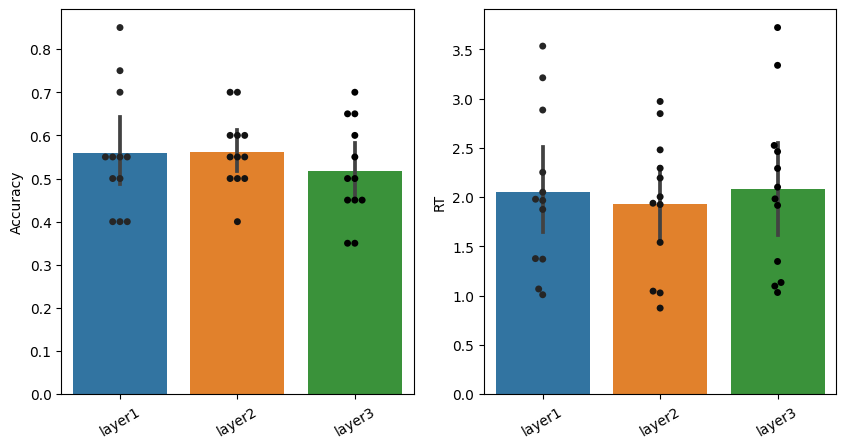

In [104]:
import seaborn as sns

fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(10,5))
sns.barplot(data=final_participants_df[['testing_layer_1_accuracy','testing_layer_2_accuracy','testing_layer_3_accuracy']],ax=axes[0])
sns.swarmplot(data=final_participants_df[['testing_layer_1_accuracy','testing_layer_2_accuracy','testing_layer_3_accuracy']],ax=axes[0],color='k')

axes[0].set_xticklabels(labels=['layer1','layer2','layer3'],rotation=30)
axes[0].set_ylabel('Accuracy')

sns.barplot(data=final_participants_df[['testing_layer_1_rt','testing_layer_2_rt','testing_layer_3_rt']],ax=axes[1])
sns.swarmplot(data=final_participants_df[['testing_layer_1_rt','testing_layer_2_rt','testing_layer_3_rt']],ax=axes[1],color='k')

axes[1].set_xticklabels(labels=['layer1','layer2','layer3'],rotation=30)
axes[1].set_ylabel('RT')


Text(0, 0.5, 'RT')

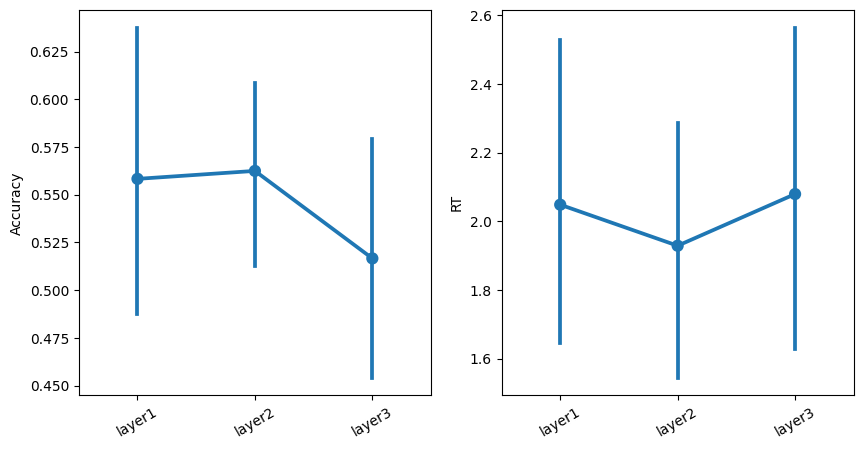

In [105]:
import seaborn as sns

fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(10,5))
sns.pointplot(data=final_participants_df[['testing_layer_1_accuracy','testing_layer_2_accuracy','testing_layer_3_accuracy']],ax=axes[0])
#sns.swarmplot(data=final_participants_df[['testing_layer_1_accuracy','testing_layer_2_accuracy','testing_layer_3_accuracy']],ax=axes[0],color='k')

axes[0].set_xticklabels(labels=['layer1','layer2','layer3'],rotation=30)
axes[0].set_ylabel('Accuracy')

sns.pointplot(data=final_participants_df[['testing_layer_1_rt','testing_layer_2_rt','testing_layer_3_rt']],ax=axes[1])
#sns.swarmplot(data=final_participants_df[['testing_layer_1_rt','testing_layer_2_rt','testing_layer_3_rt']],ax=axes[1],color='k')

axes[1].set_xticklabels(labels=['layer1','layer2','layer3'],rotation=30)
axes[1].set_ylabel('RT')


C:\Users\User\AppData\Local\Temp\ipykernel_564\2111522616.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_participants_df['worker_ID'] = final_participants_df.index


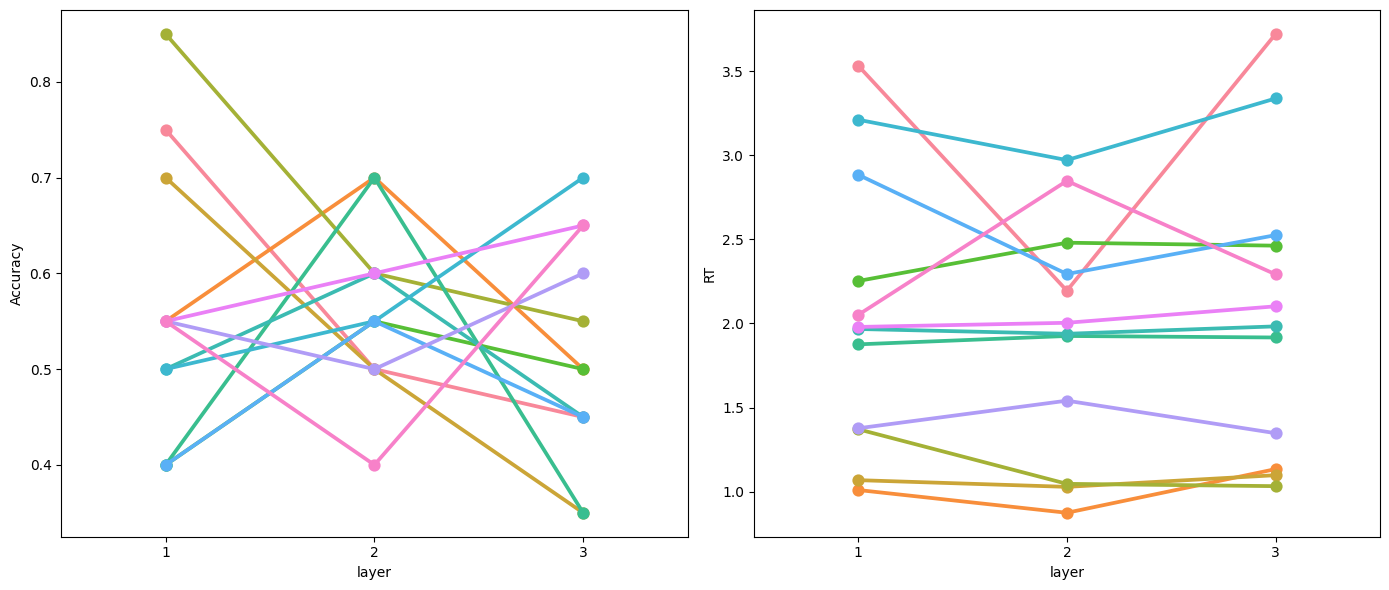

In [106]:
final_participants_df['worker_ID'] = final_participants_df.index
rt_df = pd.melt(final_participants_df,id_vars=['worker_ID'],value_vars=['testing_layer_1_rt','testing_layer_2_rt','testing_layer_3_rt'],var_name='layer')

accuracy_df = pd.melt(final_participants_df,id_vars=['worker_ID'],value_vars=['testing_layer_1_accuracy','testing_layer_2_accuracy','testing_layer_3_accuracy'],var_name='layer')


fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(14,6),sharex=True,sharey=False)


#accuracy: 
G = sns.pointplot(data=accuracy_df,x='layer', y='value', hue='worker_ID', ax=axes[0])
plt.xticks([0,1,2],['1','2','3'])
axes[0].set_ylabel('Accuracy')
axes[0].get_legend().remove() 

#rt: 
sns.pointplot(data=rt_df,x='layer', y='value', hue='worker_ID', ax=axes[1])
plt.xticks([0,1,2],['1','2','3'])
plt.ylabel('RT')
axes[1].get_legend().remove() 
plt.tight_layout()

In [107]:
#this is the updated shelf: copy from here and place in the shelf location in pavlovia.org
new_shelf_dict=shelf_dict.copy()


clean_shelf_after_test=True #change to true if you run this code after completing both encoding and test sessions and want to also resert participants that didnt come back at all... 
if clean_shelf_after_test: 


    allowed_interval_in_hours=24
    allowed_jitter=3
    allowed_interval_in_ms=[allowed_interval_in_hours-allowed_jitter,allowed_interval_in_hours+allowed_jitter]*3600*1000


    new_shelf_dict=shelf_dict.copy()
    changed_keys_list=[]
    for key in new_shelf_dict.keys():
        print(key)
        cur_entries=new_shelf_dict[key]
        if len(cur_entries)==2: 
            cur_entries[0]=999
            changed_keys_list.append(key)

        if len(cur_entries)>2:
            encoding_time=cur_entries[1]
            last_entree=cur_entries[-1]
            if last_entree == None or encoding_time == None :
                last_entree = 999
                encoding_time = 999
            if (last_entree - encoding_time) < allowed_interval_in_ms[0]:
                cur_entries[0]=999
                changed_keys_list.append(key)


        new_shelf_dict[key]=cur_entries

    print('changed entrees for:',changed_keys_list)

    ##### print the updated shelf dictionary so you can copy it from the cell output and paste in the shelf:  (change the shelf only if you run this code after both encoding and TEST has ended) ####
    new_shelf_dict


A2541C8MY0BYV3
A3RCX3IQ8L6HHW
ALCPF5NANBDSZ
A2LI71A9ZRA199
A1AMGHYG5PT0L2
AX9LZ0N55O19E
A28HB7240OFGEW
A3S10MQO4RXHM8
A1A71I3P1FXWCD
A1JJYY622DGE5L
A10YV3PH9V9KQP
A72YC75DZ8OLE
A146QN6EU8LAEI
A34PI07YOEU3ZS
A29C1SVJECJ1V8
AOMYFDVVIRWN2
A1TIKB6CAQFH2B
A3QHZCELFJ3BSN
A1HCJKXZTLF6VI
A3OUAR84WQO03Y
A3QRCBVXYI6AAK
ACKG8OU1KHKO2
AUZP4FPD6UTNU
A2DX27FIUVZYB5
A1SARRYNMZDVXB
A3QPVH0DRW0ZQV
A2GUSVGAKNEGQF
A2OL5U1YWPFBDI
A9LSEP71DNP4O
AB3920J1HAG7C
A2DRJL37OEZ3B9
A2NCVGGFYM2KWD
A2RC45D8LPJ39B
A3PDGYYLZ5WQ96
AF9VULR3VWR5I
A377O7EE412E7T
A23KAJRDVCVGOE
A6ZLFXYDXQAKE
A3948CIS0U9R41
AE33JO53WTHZQ
A2APG8MSLJ6G2K
A1JBG197ZBOPB4
A3QJ0LIK6SS3PG
A3CCEIJXJ10GST
A3GH8ENBIFBGY
A2CZ5PS567SA10
A3I40B0FATY8VH
A2N9U74YIPDQ9F
A10JXOU89D5RXR
A34YNEN8UUI3CD
A3TMVAECAVF9X5
A11BQAB549UAEG
A178HXQENEAI65
AOMSOIGOYPFXX
A361512FNHY889
A2OT9ZJC4MQBS8
A3DW5DN6ZR69OQ
A3RVHUY67SVXQV
A5P15BDXCVG32
A262YEPP7TVFWA
A2VO8C41JJIQY9
A39WZD2C8BPP01
A206WLS4KMBH86
A3QG7EQGHGDO5W
A27T7EV4ANR70J
A1SL10V8CDNI9H
A1K03E01SYT8OF
A1AA32T87

In [108]:
#find all participants that exists in the shelf, and make sure they have a participantion code (so they wont be able to come back to this experiemnt)
all_shelf_workers_that_are_assigned_participantion=[]
for curr_key in shelf_dict.keys():
    if curr_key in workers_df['Worker ID'].values:
        workers_df.loc[workers_df['Worker ID']==curr_key,qualification_name_for_entire_experiment]=1
        all_shelf_workers_that_are_assigned_participantion.append(curr_key)

print(f'{len(all_shelf_workers_that_are_assigned_participantion)} were given a {qualification_name_for_entire_experiment}, names: {all_shelf_workers_that_are_assigned_participantion}')

#create a new shelf, that only contains the ids and numbers of valid participants (this is so we wont re-use thier custom trials order (csvs))
new_shelf_dict=dict()
for sub_id in final_participants_df.index: 
    new_shelf_dict[sub_id]=shelf_dict[sub_id]
new_shelf_dict  


# add the final state of the previous batch 
previous_batch = 'batch ' + str(int(batch_name[-1]) - 1)
root_dirs = list(PATH_TO_BATCH.parent.iterdir())
target_dir = PATH_TO_BATCH.parent/ previous_batch
if target_dir in root_dirs:
    path_final_state_shelf = target_dir / 'shelf final state.txt'
    with open(path_final_state_shelf) as f:
        data = f.read()
        shelf_dict = json.loads(data)
    
    new_shelf_dict = new_shelf_dict | shelf_dict

print('\n\ncopy the following dictionary content to the pavlovia dictionary, and to the "shelf final state.txt"\n')
json.dumps(new_shelf_dict)

67 were given a UPDATE-completed birds memory rep, names: ['A2541C8MY0BYV3', 'A3RCX3IQ8L6HHW', 'ALCPF5NANBDSZ', 'A2LI71A9ZRA199', 'A1AMGHYG5PT0L2', 'AX9LZ0N55O19E', 'A3S10MQO4RXHM8', 'A1JJYY622DGE5L', 'A10YV3PH9V9KQP', 'A72YC75DZ8OLE', 'A146QN6EU8LAEI', 'AOMYFDVVIRWN2', 'A3QHZCELFJ3BSN', 'A1HCJKXZTLF6VI', 'A3OUAR84WQO03Y', 'ACKG8OU1KHKO2', 'AUZP4FPD6UTNU', 'A2DX27FIUVZYB5', 'A1SARRYNMZDVXB', 'A3QPVH0DRW0ZQV', 'A2GUSVGAKNEGQF', 'A2OL5U1YWPFBDI', 'A9LSEP71DNP4O', 'AB3920J1HAG7C', 'A2DRJL37OEZ3B9', 'A2NCVGGFYM2KWD', 'A2RC45D8LPJ39B', 'A3PDGYYLZ5WQ96', 'A23KAJRDVCVGOE', 'A6ZLFXYDXQAKE', 'A3948CIS0U9R41', 'AE33JO53WTHZQ', 'A2APG8MSLJ6G2K', 'A3QJ0LIK6SS3PG', 'A3CCEIJXJ10GST', 'A3GH8ENBIFBGY', 'A2CZ5PS567SA10', 'A3I40B0FATY8VH', 'A2N9U74YIPDQ9F', 'A10JXOU89D5RXR', 'A3TMVAECAVF9X5', 'A11BQAB549UAEG', 'A178HXQENEAI65', 'AOMSOIGOYPFXX', 'A2OT9ZJC4MQBS8', 'A3DW5DN6ZR69OQ', 'A3RVHUY67SVXQV', 'A262YEPP7TVFWA', 'A2VO8C41JJIQY9', 'A39WZD2C8BPP01', 'A206WLS4KMBH86', 'A3QG7EQGHGDO5W', 'A1SL10V8CDNI9H',

'{"A146QN6EU8LAEI": [10, 1675268305246, 1676374592899, 1676374725332, 1676381532863, 1676430249300], "A23KAJRDVCVGOE": [26, 1675276124944, 1676409015964], "A2541C8MY0BYV3": [0, 1675267981506, 1676383763427, 1676386591184, 1676396903851], "A2CZ5PS567SA10": [32, 1675278325911, 1676397348223, 1676412883511, 1676413063897], "A2DX27FIUVZYB5": [14, 1675269782794, 1676375404180, 1676385522768, 1676388922097, 1676392825624, 1676395153717], "A2LI71A9ZRA199": [3, 1675268051443, 1676446070481], "A2OT9ZJC4MQBS8": [42, 1675289466228, 1676374250744, 1676374733608, 1676390106118, 1676394647144, 1676395849623, 1676401454657, 1676414292695], "A2VY5GKTXHLC8Q": [53, 1675317857489, 1676381397841, 1676381509570, 1676389287072, 1676464739743], "A3OUAR84WQO03Y": [12, 1675269275539, 1676375238005, 1676388901171, 1676395225696], "A9LSEP71DNP4O": [19, 1675270646432, 1676384946326, 1676388662255, 1676397054045], "ALCPF5NANBDSZ": [2, 1675268048545, 1676405406780], "AUZP4FPD6UTNU": [15, 1675269450862, 167637443218

In [109]:
batch_workers_df_extended.to_csv(PATH_TO_BATCH / path.Path(batch_name+'_workers_results_extended_with_disqualification.csv'))
workers_df.to_csv(PATH_TO_BATCH / path.Path(batch_name+'_workers_results_for_upload_after_encoding_and_test.csv'))
